# Reading data

In [192]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
plt.close("all")

In [193]:
#Ref: https://medium.com/analytics-vidhya/tinder-data-54ba494e0a59
f = open('Data/myData/data.json', 'r', encoding="utf8")
data = json.load(f)["Usage"]

df = pd.DataFrame.from_dict(data)
df.index.name = "Date"
df.head()
# df.describe()

,app_opens,swipes_likes,swipes_passes,superlikes,matches,messages_sent,messages_received,advertising_id,idfa
Date,,,,,,,,,
2022-11-19,33,4,394,0,1,2,4,,
2022-11-20,15,14,714,0,0,0,0,,
2022-11-21,7,2,36,0,0,0,0,,
2022-11-22,4,2,51,0,1,0,0,,
2022-11-23,5,1,23,0,2,0,1,,


In [194]:
df = df.drop(["superlikes", "advertising_id", "idfa"], axis = 1)
df.index = pd.to_datetime(df.index)

df_weekly = df.resample("BMS").sum()

df_scaled = df_weekly.resample({"","M"}).sum()
df_scaled["swipes_passes_pct"] = 100*df_scaled["swipes_passes"] /(df_scaled["swipes_likes"]  + df_scaled["swipes_passes"] )
df_scaled["swipes_likes"] = 100*df_scaled["swipes_likes"] /(df_scaled["swipes_likes"]  + df_scaled["swipes_passes"] )
df_scaled["swipes_passes"] = df_scaled["swipes_passes_pct"]
df_scaled = df_scaled.drop("swipes_passes_pct", axis = 1)
# df_scaled = df_scaled["swipes_likes"].transform(lambda x: 100*x/(df_weekly["swipes_likes"]+df_weekly["swipes_passes"]))

df_weekly.head()
df_scaled.head()
# df = df.groupby()

ValueError: Invalid frequency: {'', 'M'}

# Visualizaiton

array([[<AxesSubplot:xlabel='app_opens', ylabel='app_opens'>,
        <AxesSubplot:xlabel='swipes_likes', ylabel='app_opens'>,
        <AxesSubplot:xlabel='swipes_passes', ylabel='app_opens'>,
        <AxesSubplot:xlabel='matches', ylabel='app_opens'>,
        <AxesSubplot:xlabel='messages_sent', ylabel='app_opens'>,
        <AxesSubplot:xlabel='messages_received', ylabel='app_opens'>],
       [<AxesSubplot:xlabel='app_opens', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='swipes_likes', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='swipes_passes', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='matches', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='messages_sent', ylabel='swipes_likes'>,
        <AxesSubplot:xlabel='messages_received', ylabel='swipes_likes'>],
       [<AxesSubplot:xlabel='app_opens', ylabel='swipes_passes'>,
        <AxesSubplot:xlabel='swipes_likes', ylabel='swipes_passes'>,
        <AxesSubplot:xlabel='swipes_passes', ylabel='swipes_passes'

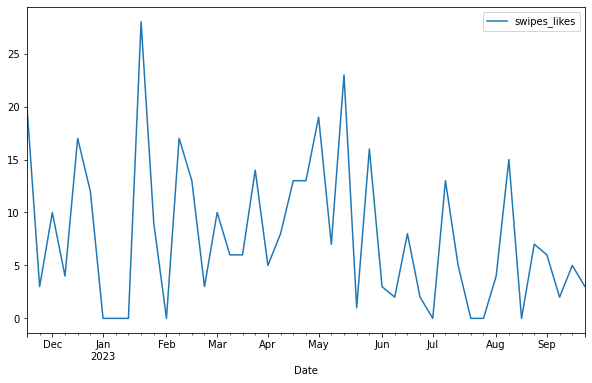

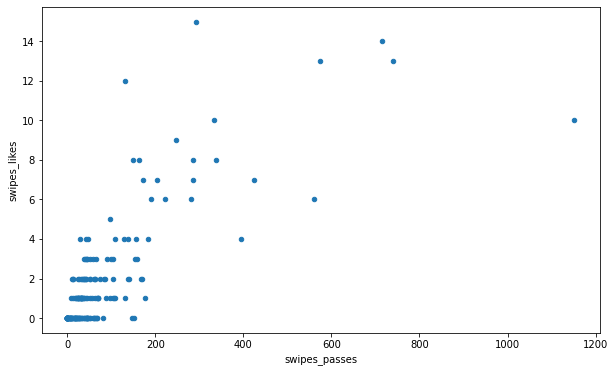

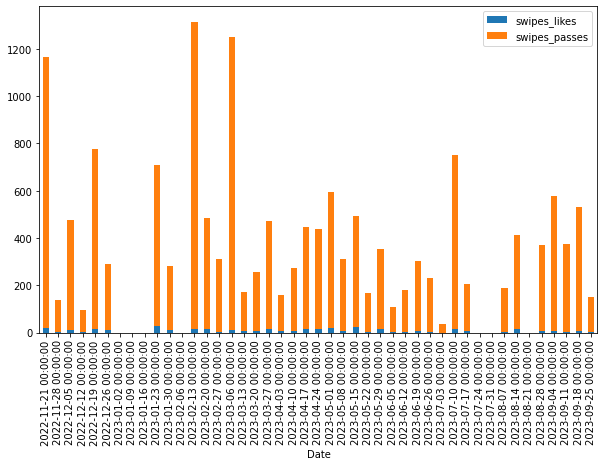

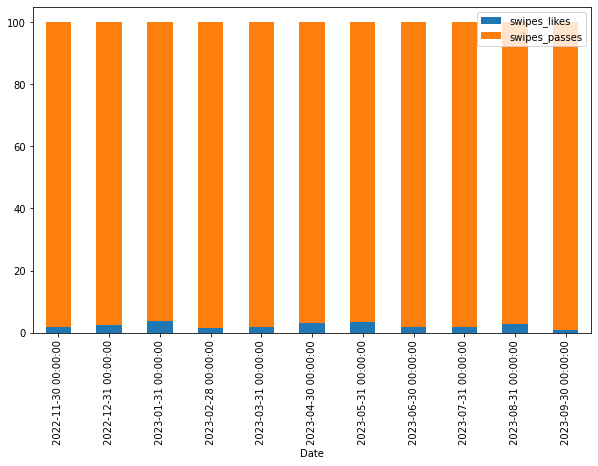

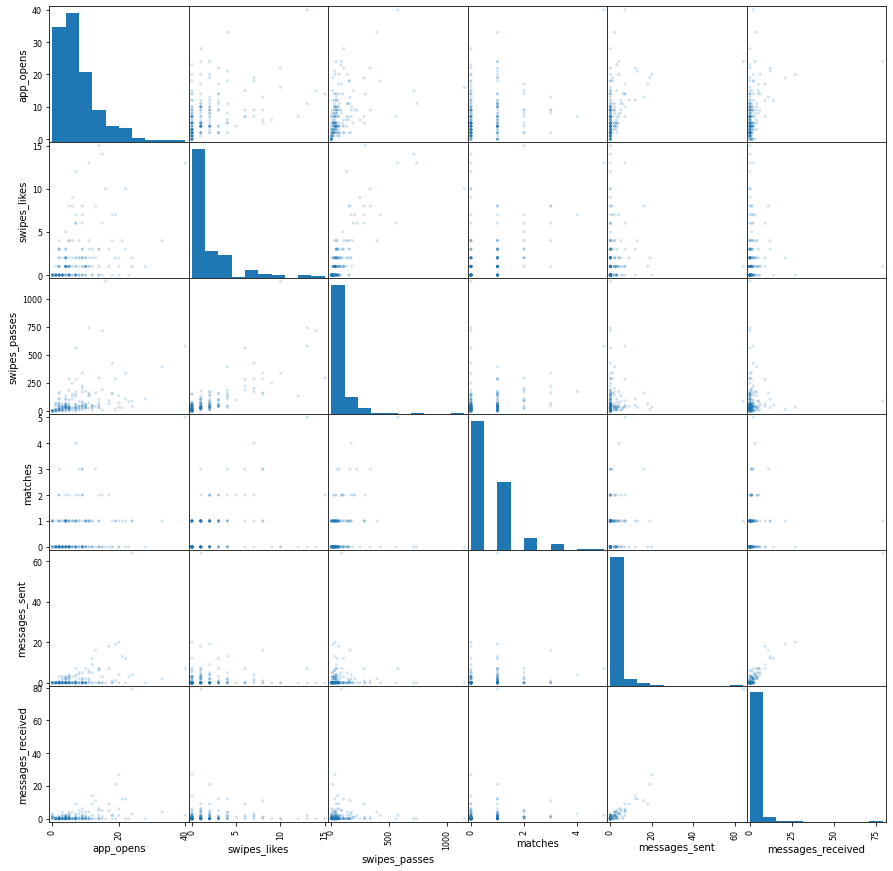

In [ ]:

df_weekly.plot(y = "swipes_likes", figsize=(10, 6))
df.plot.scatter(x = "swipes_passes", y = "swipes_likes", figsize=(10, 6))
df_weekly.plot.bar(y = ["swipes_likes", "swipes_passes"], stacked = True, figsize=(10, 6))
df_scaled.plot.bar(y = ["swipes_likes", "swipes_passes"], stacked = True, figsize=(10, 6))
pd.plotting.scatter_matrix(df, alpha = .2, figsize=(15, 15))